In [3]:
import pandas as pd 
import numpy as np
import datetime
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt 
%matplotlib inline

In [41]:
def make_Xy(coin):
    data = pd.read_csv('{}.csv'.format(coin.upper()))
    data['date'] = data.date.apply(datetime.datetime.fromtimestamp)
    data.set_index('date', inplace=True)

    price = ['open','close','high','low']
    data['price'] = data[price].mean(axis=1)
    data['price_change'] = data.price.pct_change()
    data['spread']  = data.open - data.close

    data['next'] = data.price.shift(1)
    data['change'] = (data.next - data.price)
    data.drop(price,axis=1,inplace=True)

    pos = np.percentile(data.change.dropna(),50 + 25)
    neg = np.percentile(data.change.dropna(),50- 25)
    
    def up_down(row):
        """returns if the next movement or up or down"""
        if row > pos:
            return 1
        elif row < neg:
            return -1
        else:
            return 0   

    data['up_down'] = data.change.apply(up_down)
#     ### creating the SMAs
    data['sma_5'] = data['price'].rolling(5).mean()
    data['sma_10'] = data['price'].rolling(10).mean()

#     data['mean_spread3'] = data['spread'].rolling(3).mean()
#     data['mean_spread6'] = data['spread'].rolling(5).mean()


#     data['mean_quote_volume3'] = data['quoteVolume'].rolling(3).mean()
#     data['mean_quote_volume5'] = data['quoteVolume'].rolling(5).mean()

#     data['pc_ch_5'] = data.sma_5.pct_change()
#     data['pc_ch_10'] = data.sma_10.pct_change()

#     data['sma5_ask_diff'] = (data.sma_5  - data.price)
#     data['sma10_ask_diff'] = (data.sma_10  - data.price)

    data.dropna(inplace=True)


    X = data.drop(['change','up_down','next','price','sma_5','sma_10'],axis=1)
    X = X.values
    y = data.up_down.values
    return X,y 

In [42]:
X , y = make_Xy('xem')

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
X_train.shape

(52817, 5)

In [44]:
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)
X_train_std.shape

(52817, 5)

In [45]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [46]:
lda=LinearDiscriminantAnalysis(n_components=2)

In [47]:
X_train_lda = lda.fit_transform(X_train_std,y_train)
X_test_lda = lda.transform(X_test_std)
X_train_lda.shape

(52817, 2)

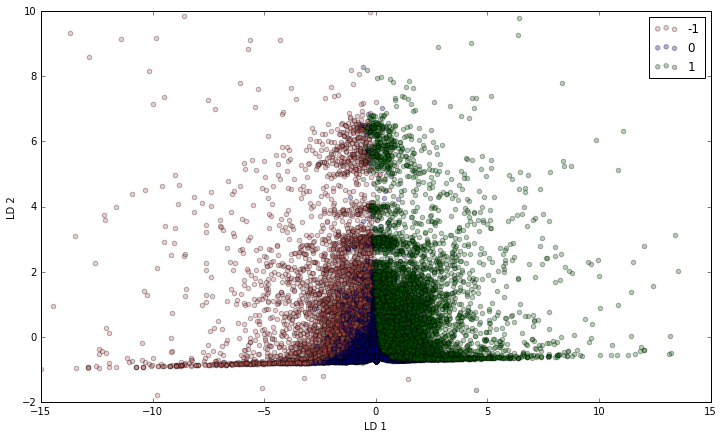

In [48]:
plt.figure(figsize=(12,7))

colors = ['indianred', 'darkblue', 'darkgreen']
for l, c in zip(np.unique(y_train), colors):
     plt.scatter(X_train_lda[y_train==l, 0],
         X_train_lda[y_train==l, 1],
         c=c, label=l,alpha=0.3)
        
# for l, c in zip(np.unique(y_test), colors):
#      plt.scatter(X_test_lda[y_test==l, 0],
#          X_test_lda[y_test==l, 1],
#          c=c, label=l,alpha=0.1,marker='X')

plt.xlim(-15,15)
plt.ylim(-2,10)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='upper right')
plt.show()

In [49]:
lda.explained_variance_ratio_

array([ 0.74346797,  0.25653203])

In [50]:
model = RandomForestClassifier(n_estimators=1000).fit(X_train_lda,y_train)

In [51]:
y_pred = model.predict(X_test_lda)
confusion_matrix(y_test, y_pred)

array([[3136,   83,    7],
       [ 151, 6508,  176],
       [   9,   85, 3050]])

In [52]:
accuracy_score(y_test,y_pred)

0.96130253691783418

In [86]:
import xgboost

In [87]:
xg = xgboost.XGBClassifier(n_estimators=1000)

In [88]:
xg.fit(X_train_lda,y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [89]:
y_pred = xg.predict(X_test_lda)
confusion_matrix(y_test, y_pred)

array([[2979,  127,   31],
       [ 245, 6332,  282],
       [  22,  165, 3022]])

In [90]:
accuracy_score(y_test,y_pred)

0.93396440742143128

In [34]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train_lda,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [35]:
y_pred = svc.predict(X_test_lda)
confusion_matrix(y_test, y_pred)

array([[2986,  142,   27],
       [ 267, 6289,  272],
       [  28,  153, 3041]])

In [36]:
accuracy_score(y_test,y_pred)

0.93267701628171151

In [65]:
from sklearn.decomposition import KernelPCA

In [68]:
t=KernelPCA(n_components=2)

In [73]:
X_train_iso = t.fit_transform(X_train_std)

MemoryError: 

In [ ]:
t.n_components

In [ ]:
plt.figure(figsize=(12,7))
colors = ['indianred', 'darkblue', 'darkgreen']
for l, c in zip(np.unique(y_train), colors):
     plt.scatter(X_train_iso[y_train==l, 0],
         X_train_iso[y_train==l, 1],
         c=c, label=l,alpha=0.3)
        

plt.xlim(-15,15)
plt.ylim(-2,10)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='upper right')
plt.show()

In [53]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 